# Aligner Inference

This notebook will walk through the process of performing inference on an already-trained Aligner model.

TODO: Fill this in

In [1]:
# Start with some imports so we can visualize alignments and load the checkpoint
%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import IPython.display as ipd

import librosa
import soundfile as sf
import torch

from nemo.collections.tts.models import AlignerModel
from omegaconf import OmegaConf

[NeMo W 2022-02-25 14:51:30 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.


## Setup

Let's start by loading the checkpoint, which should have automatically been saved by the trainer as a file in the output directory's `checkpoints/` folder called `Aligner.nemo`.

Please update `ckpt_path` in the cell below to the appropriate location on your machine.

In [ ]:
# Set device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Replace the following with the path to your Aligner model checkpoint
ckpt_path = "~/Desktop/NeMo/nemo_experiments/Aligner/LJSpeech_CMUdict_Aligner_2022-02-16/checkpoints/Aligner.nemo"
aligner = AlignerModel.restore_from(ckpt_path, map_location=device)

# This should be set to whatever sample rate your model was trained on
target_sr = 22050

Now we'll load an audio file and input the corresponding transcript. The audio file will be resampled to the `target_sr` given above.

This example uses the first sample from the NVIDIA validation split of LJSpeech, which is file `LJ022-0023.wav`. You can use whatever you'd like, of course, but this tutorial will refer to the text for this sample specifically for a concrete example.

If you'd like to download the LJSpeech dataset to use the same example, you can find it [here](https://keithito.com/LJ-Speech-Dataset/).

In [3]:
# This tutorial uses a sample from the NVIDIA validation split of LJSpeech.
# Please change the following two lines to reflect your audio file and transcript.
audio_path = "/data3/LJSpeech/LJSpeech-1.1/wavs/LJ022-0023.wav"
text_raw = "The overwhelming majority of people in this country know how to " \
    "sift the wheat from the chaff in what they hear and what they read."

# Load audio and resample if necessary
audio_data, orig_sr = sf.read(audio_path)
if orig_sr != target_sr:
    audio_data = librosa.core.resample(audio_data, orig_sr=orig_sr, target_sr=target_sr)

# Let's double-check that everything matches up!
print("Transcript:")
print(text_raw)
ipd.Audio(audio_data, rate=target_sr)

Transcript:
The overwhelming majority of people in this country know how to sift the wheat from the chaff in what they hear and what they read.


### Audio Preprocessing

The Aligner model takes in a mel spectrogram as input, so we'll need to convert our audio signal before we can evaluate it. The trained model has a preprocessor that will do this for us once we find the audio data length.

In [30]:
# Retrieve audio length for the model's preprocessor
audio_len = torch.tensor(audio_data.shape[0], device=device).long()

# Need to unsqueeze the audio data and audio_len to simulate a batch size of 1
audio = torch.tensor(audio_data, dtype=torch.float, device=device).unsqueeze(0)
audio_len = torch.tensor(audio_len).unsqueeze(0)
print(f"Audio batch shape: {audio.shape}")
print(f"Audio length shape: {audio_len.shape}\n")

# Generate the spectrogram!
spec, spec_len = aligner.preprocessor(input_signal=audio, length=audio_len)
print(f"Spec batch shape: {spec.shape}")

[NeMo W 2022-02-25 15:13:26 nemo_logging:349] /tmp/ipykernel_21434/2955961377.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
      audio_len = torch.tensor(audio_len).unsqueeze(0)
    


Audio batch shape: torch.Size([1, 196509])
Audio length shape: torch.Size([1])

Spec batch shape: torch.Size([1, 80, 768])


Let's take a look at the spectrogram to make sure it looks how we'd expect.

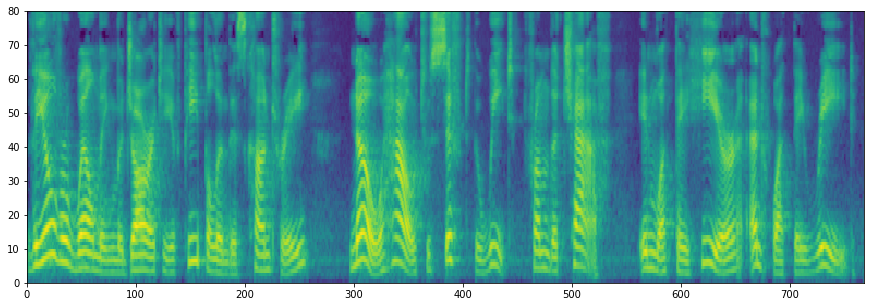

In [5]:
# Plot the spectrogram
plt.figure(figsize=(15,5))
plt.pcolormesh(spec[0].cpu().numpy(), cmap='viridis')

If the above looks like a spectrogram, we can move on to text preprocessing.

### Text Preprocessing

Now, we need to preprocess the text to be passed in to the model. This involves normalization, as well as conversion of the words in the transcript to phonemes where possible. OOV words, as well as words with multiple pronunciations, are ignored and kept as graphemes.

Let's take a look at these steps, one at a time.

In [6]:
# First, a standard English normalization of the text.
# Nothing too wild here!
text_normalized = aligner.normalizer.normalize(text_raw)
print(text_normalized)

The overwhelming majority of people in this country know how to sift the wheat from the chaff in what they hear and what they read .


At this point, we could normally just run the normalized text through the model's `tokenizer`, which would run G2P (grapheme to phoneme) conversion and spit out text tokens to pass into the model directly. But just to illustrate what happens within the tokenizer, let's take a look at its G2P step.

(If you are writing your own inference script, you can leave the code in this next cell out entirely, as it's purely illustrative.)

In [7]:
# The intermediate G2P step.
# This part is usually hidden behind just calling `tokenizer()`, but we show it here to illustrate what happens.
text_g2p = aligner.tokenizer.g2p(text_normalized)
print(text_g2p)
print(f"Length: {len(text_g2p)}")

['t', 'h', 'e', ' ', 'o', 'v', 'e', 'r', 'w', 'h', 'e', 'l', 'm', 'i', 'n', 'g', ' ', 'M', 'AH0', 'JH', 'AO1', 'R', 'AH0', 'T', 'IY0', ' ', 'o', 'f', ' ', 'P', 'IY1', 'P', 'AH0', 'L', ' ', 'i', 'n', ' ', 't', 'h', 'i', 's', ' ', 'K', 'AH1', 'N', 'T', 'R', 'IY0', ' ', 'N', 'OW1', ' ', 'HH', 'AW1', ' ', 't', 'o', ' ', 'S', 'IH1', 'F', 'T', ' ', 't', 'h', 'e', ' ', 'w', 'h', 'e', 'a', 't', ' ', 'F', 'R', 'AH1', 'M', ' ', 't', 'h', 'e', ' ', 'CH', 'AE1', 'F', ' ', 'i', 'n', ' ', 'w', 'h', 'a', 't', ' ', 'DH', 'EY1', ' ', 'HH', 'IY1', 'R', ' ', 'a', 'n', 'd', ' ', 'w', 'h', 'a', 't', ' ', 'DH', 'EY1', ' ', 'r', 'e', 'a', 'd', ' ', '.']
Length: 120


We can see that some words have been converted to phonemes (e.g. "people" turned into `["P", "IY1", "P", "AH0", "L"]`), while some have stayed as graphemes (e.g. "the" is still `["t", "h", "e"]`). As mentioned above, this is because any words with unique and known pronunciations are converted, but other words may have multiple possible pronunciations. CMUdict lists three for "the": `"DH AH0"`/`"DH AH1"`/`"DH IY0"`.

The next cell shows what we'd normally run right after we normalize the text. This gets us our text tokens. (The length increases by 2 if `pad_with_space` was set for the model.)

In [8]:
# The tokenizer runs G2P and then encodes each token.
text_tokens = aligner.tokenizer(text_normalized)
print(text_tokens)
print(f"Length: {len(text_tokens)}")

# We need these to be torch tensors before passing them in as input, of course
text = torch.tensor(text_tokens, device=device).unsqueeze(0).long()
text_len = torch.tensor(len(text_tokens), device=device).unsqueeze(0).long()
print("\nAfter unsqueezing...")
print(f"Text input shape: {text.shape}")
print(f"Text length shape: {text_len.shape}")

[0, 89, 77, 74, 0, 84, 91, 74, 87, 92, 77, 74, 81, 82, 78, 83, 76, 0, 11, 31, 8, 35, 15, 31, 18, 55, 0, 84, 75, 0, 14, 56, 14, 31, 10, 0, 78, 83, 0, 89, 77, 78, 88, 0, 9, 32, 12, 18, 15, 55, 0, 12, 59, 0, 7, 38, 0, 89, 84, 0, 16, 53, 5, 18, 0, 89, 77, 74, 0, 92, 77, 74, 70, 89, 0, 5, 15, 32, 11, 0, 89, 77, 74, 0, 2, 29, 5, 0, 78, 83, 0, 92, 77, 70, 89, 0, 4, 50, 0, 7, 56, 15, 0, 70, 83, 73, 0, 92, 77, 70, 89, 0, 4, 50, 0, 87, 74, 70, 73, 0, 98, 0]
Length: 122

After unsqueezing...
Text input shape: torch.Size([1, 122])
Text length shape: torch.Size([1])


Now we have our audio data and encoded text!

## Inference

Now that we have the audio and tokenized text, we can pass it through the trained model and get an alignment.

In [33]:
# Run the aligner!
with torch.no_grad():
    attn_soft, attn_logprob = aligner(spec=spec, spec_len=spec_len, text=text, text_len=text_len)

# "Unbatch" the results
attn_soft = attn_soft[0, 0, :, :].data.cpu().numpy()
attn_logprob = attn_logprob[0, 0, :, :].data.cpu().numpy()
print(f"Dimensions should be (spec_len={spec_len[0].data}, text_len={text_len[0].data}) for both:")
print(f"Soft attention matrix shape: {attn_soft.shape}")
print(f"Log prob matrix shape: {attn_logprob.shape}")

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
Dimensions should be (spectrogram length=768, text length=122) for both:
Soft attention matrix shape: (768, 122)
Log prob matrix shape: (768, 122)


Now that we have the soft alignments, we can take a look at how the model matches up text tokens and audio input. This should roughly be a monotonically decreasing diagonal line (towards the bottom right).

We transpose the soft attention matrix in order to show it more "naturally," that is, with the text along the vertical edge (Y-axis) and an increase in the X-axis (left-to-right) value corresponding with moving forward in time through the spectrogram.

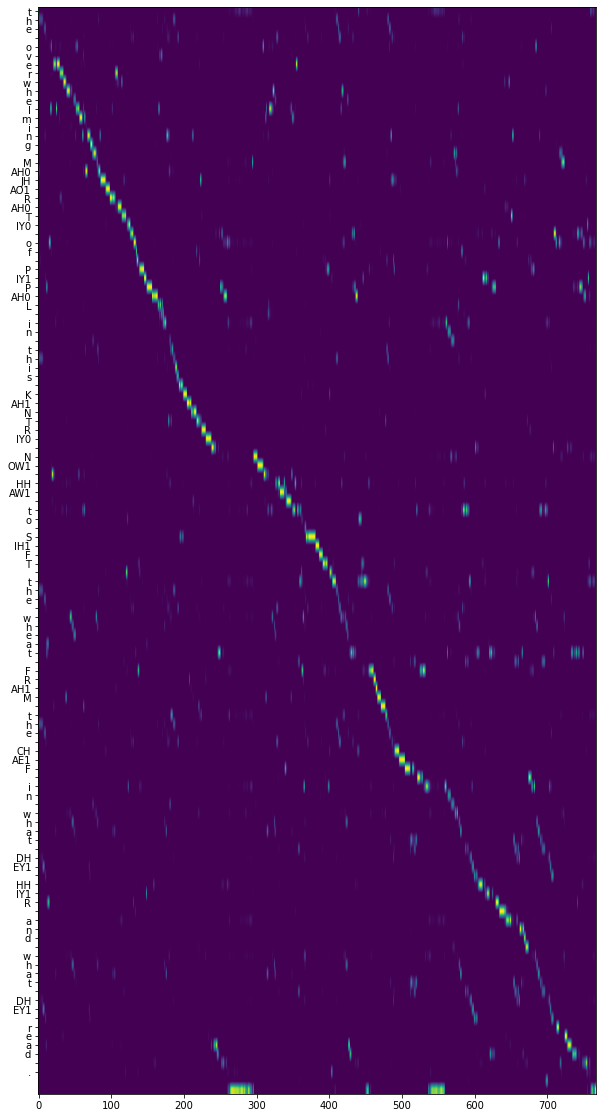

In [48]:
# Visualize soft attention matrix.
fig, ax = plt.subplots(figsize=(10,20))
_ = ax.imshow(attn_soft.transpose(), origin='upper', aspect='auto')
_ = ax.set_yticks(range(len(text_g2p)))
_ = ax.set_yticklabels(text_g2p)  # To show the text labels

In [ ]:
#TODO
#attn_hard = ... need to import to get binarize_attention